# Plot MCMC model fitting

2022.11.21 Kurama Okubo

This notebook plots the result of MCMC model fitting to estimate model parameters as well as showning the multimodality.

- 2023.3.31 update fit model
- 2023.4.3 update to use mode of distribution as best fit parameters
- 2023.4.18 update for fixed parameters and back to the `maximum likelihood parameters` as a best parameter set

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl

import emcee # MCMC sampler
import corner

# import mcmc functions
from scattermatrix import *
from MCMC_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
#---set the file path of your case study list---#
root = "../processed_data/"
h5_stats_list = [root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                    root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

h5_id = 0

averagestack_step=15

mcmc_discard_nsample = 3000 # discard samples when plotting the scatter matrix and compute the median of mcmc search

modelcase = "base" # "base" or "wlin"

output_imgdir = "../figure/MCMC_modelfit_result"

# NOTE: v1_tshift0-120 is used to demonstrate the trade-off of temperature time shift
input_datadir = "../processed_data/MCMC_sampler_20000_v2_master" #"../processed_data/MCMC_sampler_20000_v1_tshift0-120" #"../processed_data/MCMC_sampler_20000_v2_master"
modelparam_outdir = "../modelparam_data"
image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
if not os.path.exists(modelparam_outdir):
    os.makedirs(modelparam_outdir)

In [3]:
casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]

# split the version of MCMC case study
caseversion = os.path.basename(input_datadir).split("_")[3]


In [4]:
dvvmethod = casename.split('.csv')[0].split('_')[-1]

In [5]:
# read csv containing channel-weighted dvv and err
fi = h5py.File(h5_stats_list[h5_id], "r")

# Plot sampler

In [6]:
stationpairs_files = glob.glob(input_datadir+f"/*_{freqband}_{modelcase}_{dvvmethod}.pickle")
stationpairs = np.sort([os.path.basename(x).split("_")[2] for x in stationpairs_files])

In [7]:
# stationpair = stationpairs[18]#"BP.LCCB-BP.SCYB" #"BP.EADB-BP.MMNB" # "BP.MMNB-BP.SCYB"
stationpair = "BP.GHIB-BP.GHIB"
print(stationpair)

# if not os.path.exists(output_imgdir+"/{}".format(stationpair)):
#     os.makedirs(output_imgdir+"/{}".format(stationpair))
    
finame = input_datadir+"/MCMC_sampler_{}_{}_{}_{}.pickle".format(stationpair, freqband,modelcase, dvvmethod)
with open(finame, "rb") as f:
    sampler = pickle.load(f)
    modelparam = pickle.load(f)
    
modelparam["freqband"] = freqband
modelparam["dvvmethod"] = dvvmethod

BP.GHIB-BP.GHIB


In [8]:
model_keys = get_keys(modelcase)

In [9]:
# datainds = list(range(18))
# create labels of data
if modelcase=="base":
    labels = ["$a_{0}$", "$p_1$", "$a^{precip}$", "$p_2$", "$t^{shift}$", "$S_1$", "$\log_{10} t_{min}^{SS}$", "$\log_{10} t_{max}^{SS}$",
              "$S_2$", "$\log_{10} t_{min}^{PF}$", "$\log_{10} t_{max}^{PF}$", "$\log{f}$"]
elif modelcase=="wlin":
    labels = ["$a_{0}$", "$p_1$", "$a^{precip}$", "$p_2$", "$t^{shift}$", "$S_1$", "$\log_{10} t_{min}^{SS}$", "$\log_{10} t_{max}^{SS}$",
              "$S_2$", "$\log_{10} t_{min}^{PF}$", "$\log_{10} t_{max}^{PF}$", "$b_{lin}$", "$\log{f}$"]
    

if modelparam["fixparam01"]:
    labels.remove("$a^{precip}$")
    labels.remove("$\log_{10} t_{min}^{SS}$")
    labels.remove("$\log_{10} t_{min}^{PF}$")


In [10]:
labels

['$a_{0}$',
 '$p_1$',
 '$p_2$',
 '$t^{shift}$',
 '$S_1$',
 '$\\log_{10} t_{max}^{SS}$',
 '$S_2$',
 '$\\log_{10} t_{max}^{PF}$',
 '$\\log{f}$']

In [11]:
print(f"sampler number of parameter is : {sampler.ndim}.")
print(f" {len(labels)}")

sampler number of parameter is : 9.
 9


# Evaluate the model parameters with best probability

In [12]:
# get the chains of samples separately
chains_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=False)

# get the chains of log probability
chains_lnprob =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=False)

# select the chain id with the maximum log probability among the chains
chains_lnprobmaxarg = np.argmax(chains_lnprob, axis=0)

# extract the single chain of log probability with its maximum
chains_lnprobmax = np.array([chains_lnprob[x, i] for i, x in enumerate(chains_lnprobmaxarg)])

# compare the maximum log probability with different chains and get the best chain id
lnprob_maxchain_id = np.argmax(chains_lnprobmax)

# extract the best chain of samples
flat_samples_maxprob = chains_samples[:, lnprob_maxchain_id, :]

# obtain the model parameters with the best log probability
maxlnprob_theta = flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :]

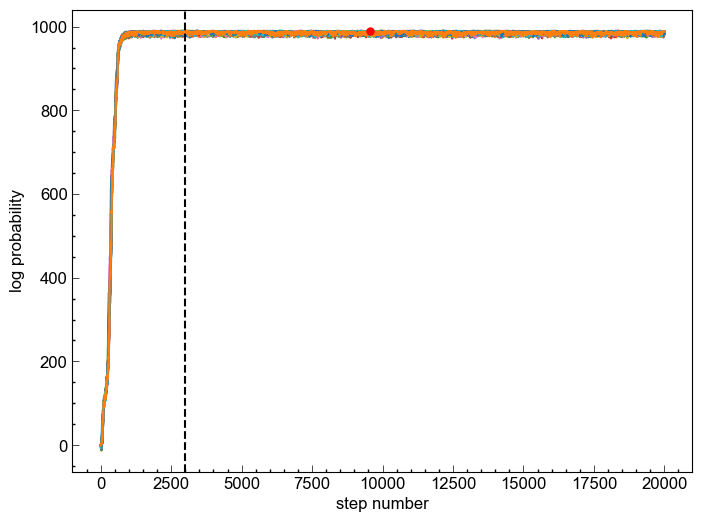

In [13]:
# plot the evolution of log probability
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
chain_log_prob_plot = sampler.get_log_prob(discard=0, thin=1, flat=False)

ax.plot(chain_log_prob_plot);
ax.axvline(mcmc_discard_nsample, c="k", ls="--")
max_logprob_ind = chains_lnprobmaxarg[lnprob_maxchain_id] # plot the iteration of max log prob
ax.plot(max_logprob_ind+mcmc_discard_nsample, chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], "ro", ms=5);
# ax.set_ylim([1350, 1420])
# ax.set_ylim([820, 960])
ax.set_xlabel("step number")
ax.set_ylabel("log probability");
foname = (output_imgdir+"/ex_MCMC_logprobability_chains_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

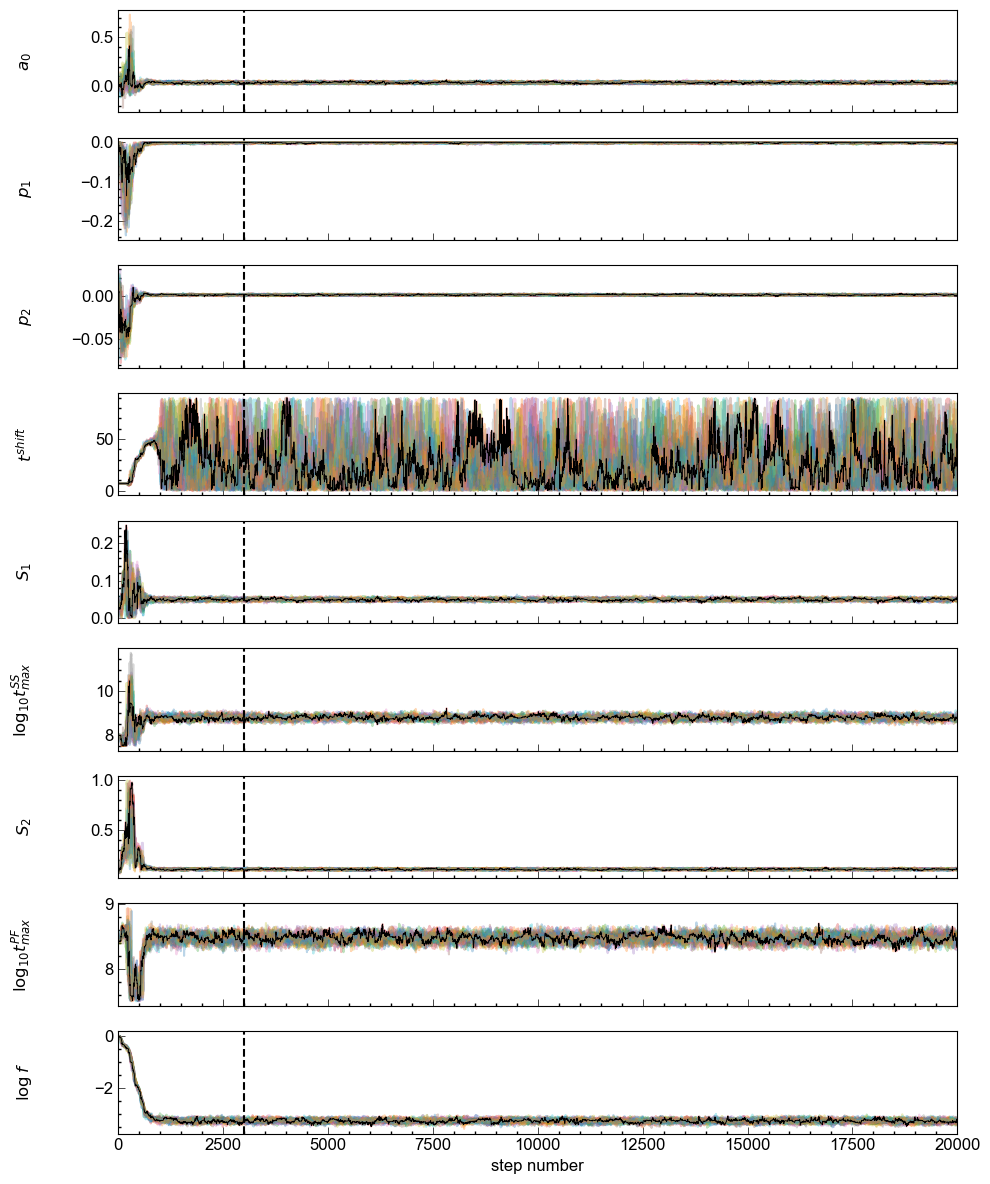

In [14]:
fig, axes = plt.subplots(sampler.ndim, figsize=(10, 12), sharex=True)
samples = sampler.get_chain()
iternum = sampler.get_chain().shape[0]

for i in range(sampler.ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.plot(samples[:, lnprob_maxchain_id, i], c="k", lw=0.6) # plot chain with the best log probabilisity
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])#model_keys[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(mcmc_discard_nsample, c="k", ls="--")
    
axes[-1].set_xlabel("step number");

foname = (output_imgdir+"/ex_MCMC_parametersearch_%s_%s_%d_%s_%s.png"%(stationpair, freqband, iternum, dvvmethod, caseversion))
fig.tight_layout()
plt.savefig(foname)

In [15]:
# Plot dv/v factors
# read observed dvv and err
dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
err_data = np.array(fi["dvv/{}/err".format(stationpair)])

modelparam["dvv_data"] = dvv_data
modelparam["err_data"] = err_data

## Flatten the chains of mcmc search

flat_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=True)

theta_median = []
for i in range(sampler.ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    theta_median.append(mcmc[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
# datainds_trim = [0, 1, 2, 3, 4, 5, 7, 8,10, 11]
# datainds_trim = [7,10]
datainds_trim = range(len(labels)) # plot all quantities
labels_trim=[labels[x] for x in datainds_trim]

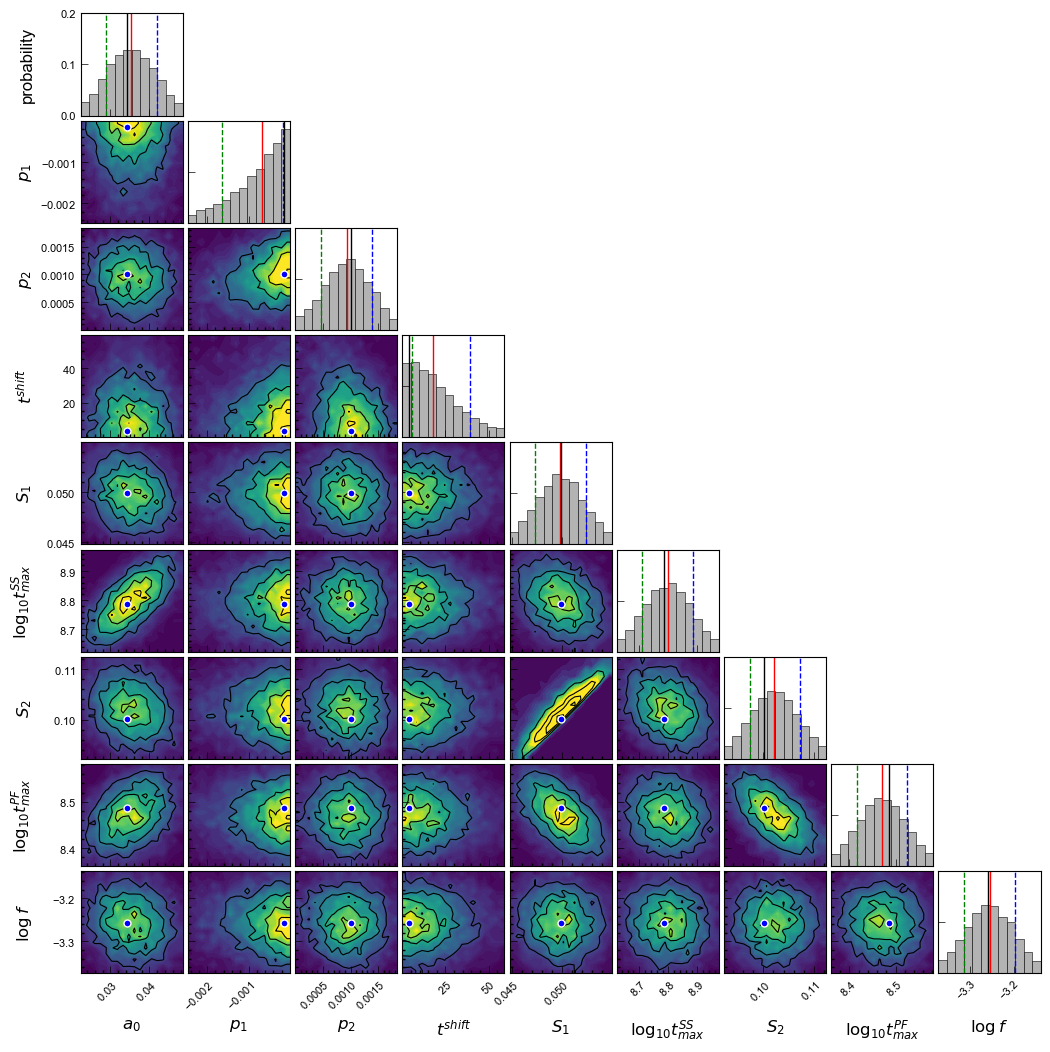

In [17]:
xranges = np.array([[-0.045, 0.045],
                 [-0.006, 0.002],
                 [0, 0.3],
                 [0.0, 0.002],
                 [0, 85],
                 [0, 0.01], #S1
                 [7.8, 11],
                 [0, 0.02], #S2
                 [7.8, 11],
                 [0.002, 0.008],])

modelparam["nbin_hist"] = 12

chains_samples_all = sampler.get_chain(discard=mcmc_discard_nsample, thin=50, flat=True)

# flat_samples_maxprob

fig, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
    xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=modelparam["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4,
    ylim_max=0.2, zlim_max=0.01, xranges=None, plot_median=True, plot_bestparam=maxlnprob_theta, labelfontsize=12, tickfontsize=8, figsize=(12, 12));

fig.align_labels();


foname = (output_imgdir+"/ex_MCMC_modelfit_factors_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

In [18]:
maxlnprob_theta

array([ 3.41602885e-02, -1.55237668e-04,  1.00012473e-03,  3.61792128e+00,
        4.99519059e-02,  8.78637300e+00,  1.00035019e-01,  8.48666988e+00,
       -3.25812433e+00])

# compute model dv/v factors   

In [19]:
modelparam["ndim"] = sampler.ndim

theta0 = maxlnprob_theta #theta_median # maxlnprob_theta: select the set of model parameters

if modelparam["fixparam01"] == True:
    # fix the aprecip, log10tmin1 and log10tmin2
    if  modelparam["modelcase"]=="base":
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:9]), axis=None)
    elif modelparam["modelcase"]=="wlin":
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:10]), axis=None)
else:
    theta = theta0

            
if modelparam["modelcase"] == "base":    
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF = model_base(theta, all=True, **modelparam)

elif modelparam["modelcase"] == "wlin":
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta, all=True, **modelparam)

In [20]:
# modelparam

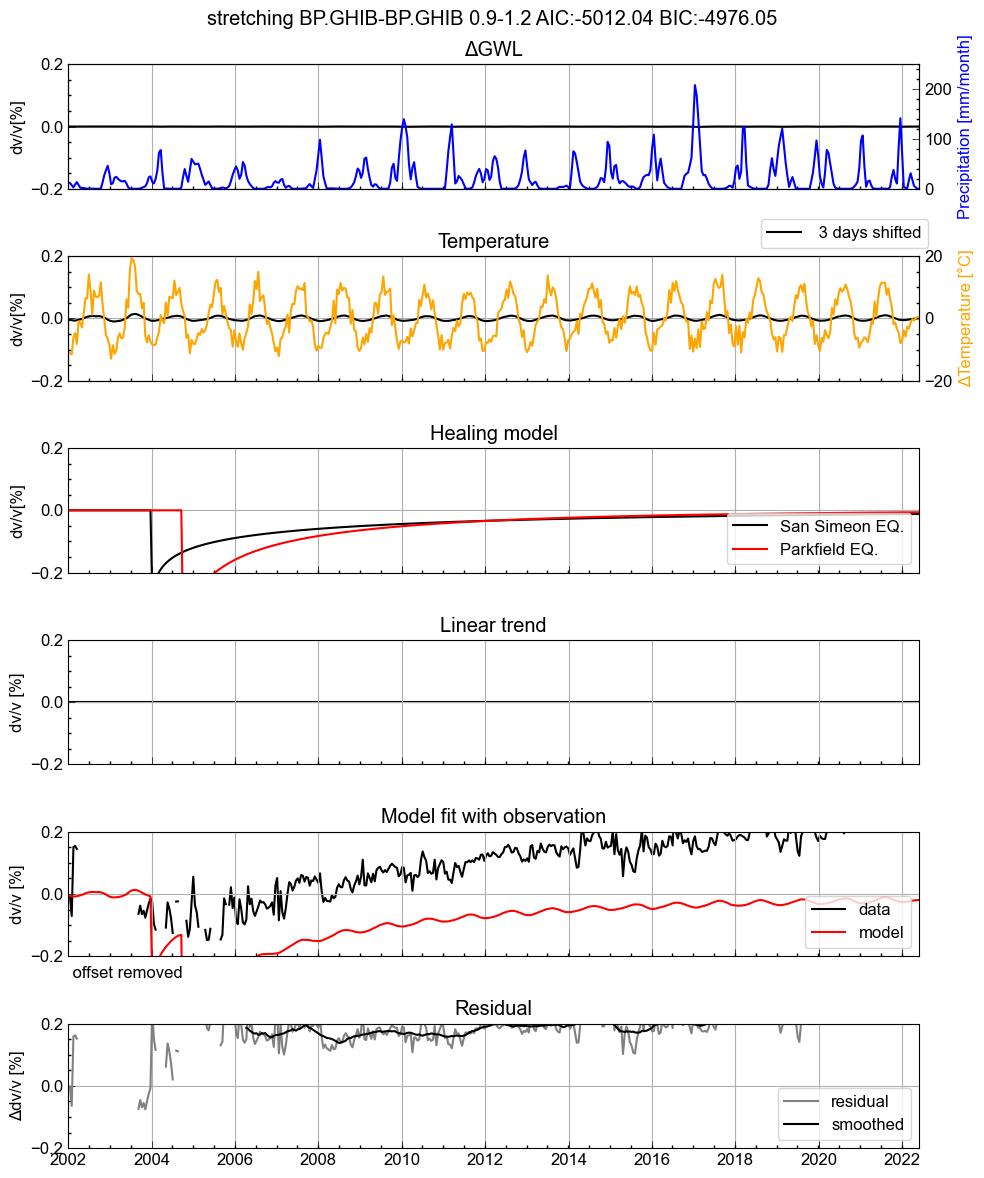

In [21]:
# plot figure
dvvmodel_IsOffsetRemoval = True # remove offset from the dv/v with the periof before San Simeon eq. of the observation
uniform_tvec = modelparam["uniform_tvec"]
tSS = datetime.datetime.fromtimestamp(modelparam["unix_tSS"])

t_shiftdays = theta[model_keys.index("t_{shiftdays}")]

fig, axs = plt.subplots(6, 1, figsize=(10,12),sharex=True)

# plot GWL
axs[0].plot(uniform_tvec, dvvgwl, "k-")
axs[0].set_title("ΔGWL")
axs[0].set_ylabel("dv/v[%]")

ax02=axs[0].twinx()
# make a plot with different y-axis using second axis object
ax02.plot(uniform_tvec, modelparam["precip"] , color="blue")
ax02.set_ylabel("Precipitation [mm/month]",color="blue")
ax02.set_ylim([0, 250])


# plot Temperature
axs[1].plot(uniform_tvec, dvvtemp, "k-", label="{:2d} days shifted".format(int(t_shiftdays)))
axs[1].set_title("Temperature")
axs[1].set_ylabel("dv/v[%]")

ax12=axs[1].twinx()
# make a plot with different y-axis using second axis object
ax12.plot(uniform_tvec, modelparam["CAVG"] , color="orange")
ax12.set_ylabel("ΔTemperature [°C]",color="orange")
ax12.set_ylim([-20, 20])
axs[1].legend(loc=4, bbox_to_anchor=(1.02, 1.0),)


# plot SS and PF healing
axs[2].plot(uniform_tvec, dvvhealSS, "k-", label="San Simeon EQ.")
axs[2].plot(uniform_tvec, dvvhealPF, "r-", label="Parkfield EQ.")
axs[2].set_title("Healing model")
axs[2].set_ylabel("dv/v[%]")
axs[2].legend(loc=4)

# plot trend
if modelparam["modelcase"] == "base":
    lintrend = np.zeros(len(uniform_tvec)) # plot zero trend for the case of base model
    
axs[3].plot(uniform_tvec, lintrend, ls="-", c = "k", zorder=1)
axs[3].set_title("Linear trend")
axs[3].set_ylabel("dv/v [%]")
# axs[3].legend(loc=4)

# plot dv/v
if dvvmodel_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    dvv_data = dvv_data - np.nanmean(dvv_data[offset_ind])
    dvvmodel = dvvmodel - np.nanmean(dvvmodel[offset_ind])
    axs[4].text(starttime, -0.27, " offset removed")
    
# axs[3].errorbar(uniform_tvec, dvv_data, yerr = err_data, capsize=3, ls="-", c = "k", ecolor='black', zorder=1, label="data")
axs[4].plot(uniform_tvec, dvv_data, ls="-", c = "k", zorder=1, label="data")
axs[4].plot(uniform_tvec, dvvmodel, "r-", zorder=2, label="model")
axs[4].set_title("Model fit with observation")
axs[4].set_ylabel("dv/v [%]")
axs[4].legend(loc=4)

# plot residual
axs[5].plot(uniform_tvec, dvv_data-dvvmodel, "-", c="gray", zorder=2, label="residual")
axs[5].plot(uniform_tvec, moving_average(dvv_data-dvvmodel, 20), "k-", zorder=2, label="smoothed")
axs[5].set_title("Residual")
axs[5].set_ylabel("Δdv/v [%]")
axs[5].legend(loc=4)

for i in range(len(axs)):
    axs[i].grid(True)
    axs[i].set_yticks([-0.2, 0.0, 0.2])

plt.setp(axs, xlim=[starttime, endtime])
plt.setp(axs, ylim=[-0.2,0.2])

Nmodelparam = len(theta_median)
AIC_wlin = compute_AIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim
BIC_wlin = compute_BIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim

plt.suptitle("{} {} {} AIC:{:4.2f} BIC:{:4.2f}".format(dvvmethod, stationpair, freqband, AIC_wlin, BIC_wlin))

fig.tight_layout()
# vlines = [datetime.datetime(2002, 1, 1), datetime.datetime(2020, 9, 1)] 
# ax.axvline(vlines[0], ls="-", c='b')
# ax.axvline(vlines[1], ls="-", c='b')

foname = (output_imgdir+"/ex_MCMC_modelfit_factors_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
plt.savefig(foname, dpi=150)

# Process all the station pairs

In [22]:
stationpairs_files = glob.glob(input_datadir+f"/*_{freqband}_{modelcase}_{dvvmethod}.pickle")
stationpairs = np.sort([os.path.basename(x).split("_")[2] for x in stationpairs_files])

In [23]:
print(len(stationpairs))

50


In [24]:
for stationpair in tqdm(stationpairs):
# stationpair = stationpairs[0]
    print(f"processing {stationpair}.")

#     if not os.path.exists(output_imgdir+"/{}".format(stationpair)): # update: do not distribute in the directories
#         os.makedirs(output_imgdir+"/{}".format(stationpair))

    finame = input_datadir+"/MCMC_sampler_{}_{}_{}_{}.pickle".format(stationpair, freqband, modelcase, dvvmethod)
    with open(finame, "rb") as f:
        sampler = pickle.load(f)
        modelparam_st = pickle.load(f)

    modelparam_st["freqband"] = freqband
    modelparam_st["dvvmethod"] = dvvmethod
    model_keys = get_keys(modelcase)

    # create labels of data
    if modelcase=="base":
        labels = ["$a_{0}$", "$p_1$", "$a^{precip}$", "$p_2$", "$t^{shift}$", "$S_1$", "$\log_{10} t_{min}^{SS}$", "$\log_{10} t_{max}^{SS}$",
                  "$S_2$", "$\log_{10} t_{min}^{PF}$", "$\log_{10} t_{max}^{PF}$", "$\log{f}$"]
    elif modelcase=="wlin":
        labels = ["$a_{0}$", "$p_1$", "$a^{precip}$", "$p_2$", "$t^{shift}$", "$S_1$", "$\log_{10} t_{min}^{SS}$", "$\log_{10} t_{max}^{SS}$",
                  "$S_2$", "$\log_{10} t_{min}^{PF}$", "$\log_{10} t_{max}^{PF}$", "$b_{lin}$", "$\log{f}$"]

    if modelparam["fixparam01"]:
        labels.remove("$a^{precip}$")
        labels.remove("$\log_{10} t_{min}^{SS}$")
        labels.remove("$\log_{10} t_{min}^{PF}$")
    
    #----------------------------------------------#
    # Evaluate the best parameters
    #----------------------------------------------#
    
    # get the chains of samples separately
    chains_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=False)

    # get the chains of log probability
    chains_lnprob =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=False)

    # select the chain id with the maximum log probability among the chains
    chains_lnprobmaxarg = np.argmax(chains_lnprob, axis=0)

    # extract the single chain of log probability with its maximum
    chains_lnprobmax = np.array([chains_lnprob[x, i] for i, x in enumerate(chains_lnprobmaxarg)])

    # compare the maximum log probability with different chains and get the best chain id
    lnprob_maxchain_id = np.argmax(chains_lnprobmax)

    # extract the best chain of samples
    flat_samples_maxprob = chains_samples[:, lnprob_maxchain_id, :]

    # obtain the model parameters with the best log probability
    maxlnprob_theta = flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :]

    # store to the dict
    modelparam_st["model_keys"] = model_keys
    modelparam_st["flat_samples_maxprob"] = flat_samples_maxprob
    modelparam_st["maxlnprob_theta"] = maxlnprob_theta
        
    #----------------------------------------------#
    # plot parameter search history
    #----------------------------------------------#
    fig, axes = plt.subplots(sampler.ndim, figsize=(10, 12), sharex=True)
    samples = sampler.get_chain()
    iternum = sampler.get_chain().shape[0]

    for i in range(sampler.ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], alpha=0.3)
        ax.plot(samples[:, lnprob_maxchain_id, i], c="k", lw=0.6) # plot chain with the best log probabilisity
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])#model_keys[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.axvline(mcmc_discard_nsample, c="k", ls="--")

    axes[-1].set_xlabel("step number");
    foname = (output_imgdir+f"/MCMC_parametersearch_{stationpair}_{freqband}_{iternum}_{dvvmethod}_{modelparam['modelcase']}.png")
    fig.tight_layout()
    plt.savefig(foname)

    #----------------------------------------------#
    # plot the evolution of log probability
    #----------------------------------------------#
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    chain_log_prob_plot = sampler.get_log_prob(discard=0, thin=1, flat=False)
    ax.plot(chain_log_prob_plot);
    ax.axvline(mcmc_discard_nsample, c="k", ls="--")
    max_logprob_ind = chains_lnprobmaxarg[lnprob_maxchain_id] # plot the iteration of max log prob
    ax.plot(max_logprob_ind+mcmc_discard_nsample, chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], "ro", ms=5);
    ax.set_ylim([0.95*np.max(chain_log_prob_plot), 1.02*np.max(chain_log_prob_plot)])
    ax.set_xlabel("step number")
    ax.set_ylabel("log probability");
    foname = (output_imgdir+f"/MCMC_logprobability_chains_{stationpair}_{freqband}_{iternum}_{dvvmethod}_{modelparam['modelcase']}.png")
    fig.tight_layout()
    plt.savefig(foname)
    
    # Plot dv/v factors
    # read observed dvv and err
    dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
    err_data = np.array(fi["dvv/{}/err".format(stationpair)])

    modelparam_st["dvv_data"] = dvv_data
    modelparam_st["err_data"] = err_data

    # Flatten the chains of mcmc search and find the median

    flat_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=True)

    theta_median = []
    for i in range(sampler.ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#         q = np.diff(mcmc)
#         txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
#         txt = txt.format(mcmc[1], q[0], q[1], model_keys[i])
#         display(Math(txt))
        theta_median.append(mcmc[1])

#     datainds_trim = [0, 1, 2, 3, 4, 5, 7, 8,10, 11]
    datainds_trim = range(len(labels)) # plot all quantities
    labels_trim=[labels[x] for x in datainds_trim]

    #-----------------------------------------------#
    # Plot scatter matrix
    #-----------------------------------------------#
    chains_samples_all = sampler.get_chain(discard=mcmc_discard_nsample, thin=50, flat=True)

    modelparam_st["nbin_hist"] = 12

    fig, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
        xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=modelparam["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4,
        ylim_max=0.2, zlim_max=0.01, xranges=None, plot_median=True, plot_bestparam=maxlnprob_theta, labelfontsize=12, tickfontsize=8, figsize=(12, 12));

    fig.align_labels();
    foname = (output_imgdir+"/MCMC_scattermatrix_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
    plt.savefig(foname, dpi=150)

    #-----------------------------------------------#
    # compute model dv/v factors 
    #-----------------------------------------------#

    modelparam_st["ndim"] = sampler.ndim

    # Reform the theta in the case of fixing parameters
    theta0 = maxlnprob_theta #theta_median # maxlnprob_theta: select the set of model parameters

    if modelparam["fixparam01"] == True:
        # fix the aprecip, log10tmin1 and log10tmin2
        if  modelparam["modelcase"]=="base":
            theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                              theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:9]), axis=None)
        elif modelparam["modelcase"]=="wlin":
            theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                              theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:10]), axis=None)
    else:
        theta = theta0

    if modelparam["modelcase"] == "base":    
        dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF = model_base(theta, all=True, **modelparam)

    elif modelparam["modelcase"] == "wlin":
        dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta, all=True, **modelparam)

    # plot figure
    dvvmodel_IsOffsetRemoval = True # remove offset from the dv/v with the periof before San Simeon eq. of the observation
    uniform_tvec = modelparam["uniform_tvec"]
    tSS = datetime.datetime.fromtimestamp(modelparam["unix_tSS"])

    t_shiftdays = theta[model_keys.index("t_{shiftdays}")]

    fig, axs = plt.subplots(6, 1, figsize=(10,12),sharex=True)

    # plot GWL
    axs[0].plot(uniform_tvec, dvvgwl, "k-")
    axs[0].set_title("ΔGWL")
    axs[0].set_ylabel("dv/v[%]")

    ax02=axs[0].twinx()
    # make a plot with different y-axis using second axis object
    ax02.plot(uniform_tvec, modelparam["precip"] , color="blue")
    ax02.set_ylabel("Precipitation [mm/month]",color="blue")
    ax02.set_ylim([0, 250])


    # plot Temperature
    axs[1].plot(uniform_tvec, dvvtemp, "k-", label="{:2d} days shifted".format(int(t_shiftdays)))
    axs[1].set_title("Temperature")
    axs[1].set_ylabel("dv/v[%]")

    ax12=axs[1].twinx()
    # make a plot with different y-axis using second axis object
    ax12.plot(uniform_tvec, modelparam["CAVG"] , color="orange")
    ax12.set_ylabel("ΔTemperature [°C]",color="orange")
    ax12.set_ylim([-20, 20])
    axs[1].legend(loc=4, bbox_to_anchor=(1.02, 1.0),)


    # plot SS and PF healing
    axs[2].plot(uniform_tvec, dvvhealSS, "k-", label="San Simeon EQ.")
    axs[2].plot(uniform_tvec, dvvhealPF, "r-", label="Parkfield EQ.")
    axs[2].set_title("Healing model")
    axs[2].set_ylabel("dv/v[%]")
    axs[2].legend(loc=4)

    # plot trend
    if modelparam["modelcase"] == "base":
        lintrend = np.zeros(len(uniform_tvec)) # plot zero trend for the case of base model

    axs[3].plot(uniform_tvec, lintrend, ls="-", c = "k", zorder=1)
    axs[3].set_title("Linear trend")
    axs[3].set_ylabel("dv/v [%]")
    # axs[3].legend(loc=4)

    # plot dv/v
    if dvvmodel_IsOffsetRemoval:
        offset_ind = np.where(np.array(uniform_tvec) < tSS)
        dvv_data = dvv_data - np.nanmean(dvv_data[offset_ind])
        dvvmodel = dvvmodel - np.nanmean(dvvmodel[offset_ind])
        axs[4].text(starttime, -0.27, " offset removed")

    # axs[3].errorbar(uniform_tvec, dvv_data, yerr = err_data, capsize=3, ls="-", c = "k", ecolor='black', zorder=1, label="data")
    axs[4].plot(uniform_tvec, dvv_data, ls="-", c = "k", zorder=1, label="data")
    axs[4].plot(uniform_tvec, dvvmodel, "r-", zorder=2, label="model")
    axs[4].set_title("Model fit with observation")
    axs[4].set_ylabel("dv/v [%]")
    axs[4].legend(loc=4)

    # plot residual
    axs[5].plot(uniform_tvec, dvv_data-dvvmodel, "-", c="gray", zorder=2, label="residual")
    axs[5].plot(uniform_tvec, moving_average(dvv_data-dvvmodel, 20), "k-", zorder=2, label="smoothed")
    axs[5].set_title("Residual")
    axs[5].set_ylabel("Δdv/v [%]")
    axs[5].legend(loc=4)

    for i in range(len(axs)):
        axs[i].grid(True)
        axs[i].set_yticks([-0.2, 0.0, 0.2])


    plt.setp(axs, xlim=[starttime, endtime])
    plt.setp(axs, ylim=[-0.2,0.2])

    Nmodelparam = len(theta0)
    AIC_wlin = compute_AIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim
    BIC_wlin = compute_BIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim

    plt.suptitle("{} {} AIC:{:4.2f} BIC:{:4.2f}".format(stationpair, freqband, AIC_wlin, BIC_wlin))

    fig.tight_layout()
    # vlines = [datetime.datetime(2002, 1, 1), datetime.datetime(2020, 9, 1)] 
    # ax.axvline(vlines[0], ls="-", c='b')
    # ax.axvline(vlines[1], ls="-", c='b')

    foname = (output_imgdir+"/MCMC_modelfit_factors_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
    plt.savefig(foname, dpi=150)

    # Save the data
    modelparam_st["labels"] = labels

    foname = modelparam_outdir + f"/MCMC_modelparam_{stationpair}_{dvvmethod}_{freqband}Hz_{modelparam['modelcase']}.pickle"
    with open(foname, 'wb') as fo:
        pickle.dump(modelparam_st, fo, protocol=pickle.HIGHEST_PROTOCOL)

        
    plt.close("all")    

  0%|                                                    | 0/50 [00:00<?, ?it/s]

processing BP.CCRB-BP.CCRB.


  2%|▉                                           | 1/50 [00:09<07:34,  9.27s/it]

processing BP.CCRB-BP.EADB.


  4%|█▊                                          | 2/50 [00:18<07:26,  9.30s/it]

processing BP.CCRB-BP.FROB.


  6%|██▋                                         | 3/50 [00:28<07:21,  9.38s/it]

processing BP.CCRB-BP.JCSB.


  8%|███▌                                        | 4/50 [00:37<07:16,  9.50s/it]

processing BP.CCRB-BP.LCCB.


 10%|████▍                                       | 5/50 [00:47<07:11,  9.60s/it]

processing BP.CCRB-BP.MMNB.


 12%|█████▎                                      | 6/50 [00:57<07:03,  9.63s/it]

processing BP.CCRB-BP.SCYB.


 14%|██████▏                                     | 7/50 [01:06<06:45,  9.43s/it]

processing BP.CCRB-BP.SMNB.


 16%|███████                                     | 8/50 [01:16<06:44,  9.63s/it]

processing BP.CCRB-BP.VCAB.


 18%|███████▉                                    | 9/50 [01:26<06:43,  9.84s/it]

processing BP.EADB-BP.EADB.


 20%|████████▌                                  | 10/50 [01:35<06:22,  9.56s/it]

processing BP.EADB-BP.FROB.


 22%|█████████▍                                 | 11/50 [01:46<06:27,  9.95s/it]

processing BP.EADB-BP.GHIB.


 24%|██████████▎                                | 12/50 [01:55<06:10,  9.74s/it]

processing BP.EADB-BP.JCNB.


 26%|███████████▏                               | 13/50 [02:05<05:57,  9.67s/it]

processing BP.EADB-BP.JCSB.


 28%|████████████                               | 14/50 [02:17<06:15, 10.42s/it]

processing BP.EADB-BP.LCCB.


 30%|████████████▉                              | 15/50 [02:26<05:49,  9.98s/it]

processing BP.EADB-BP.MMNB.


 32%|█████████████▊                             | 16/50 [02:39<06:06, 10.77s/it]

processing BP.EADB-BP.SCYB.


 34%|██████████████▌                            | 17/50 [02:48<05:39, 10.28s/it]

processing BP.EADB-BP.SMNB.


 36%|███████████████▍                           | 18/50 [02:57<05:21, 10.06s/it]

processing BP.EADB-BP.VCAB.


 38%|████████████████▎                          | 19/50 [03:07<05:06,  9.88s/it]

processing BP.FROB-BP.JCSB.


 40%|█████████████████▏                         | 20/50 [03:20<05:24, 10.80s/it]

processing BP.FROB-BP.LCCB.


 42%|██████████████████                         | 21/50 [03:29<05:02, 10.42s/it]

processing BP.FROB-BP.MMNB.


 44%|██████████████████▉                        | 22/50 [03:39<04:45, 10.19s/it]

processing BP.FROB-BP.SCYB.


 46%|███████████████████▊                       | 23/50 [03:49<04:29, 10.00s/it]

processing BP.FROB-BP.SMNB.


 48%|████████████████████▋                      | 24/50 [04:03<04:53, 11.29s/it]

processing BP.FROB-BP.VCAB.


 50%|█████████████████████▌                     | 25/50 [04:12<04:28, 10.75s/it]

processing BP.GHIB-BP.GHIB.


 52%|██████████████████████▎                    | 26/50 [04:22<04:09, 10.41s/it]

processing BP.GHIB-BP.JCSB.


 54%|███████████████████████▏                   | 27/50 [04:32<03:55, 10.24s/it]

processing BP.JCNB-BP.LCCB.


 56%|████████████████████████                   | 28/50 [04:48<04:27, 12.16s/it]

processing BP.JCNB-BP.MMNB.


 58%|████████████████████████▉                  | 29/50 [04:58<04:00, 11.46s/it]

processing BP.JCSB-BP.JCSB.


 60%|█████████████████████████▊                 | 30/50 [05:07<03:35, 10.79s/it]

processing BP.JCSB-BP.LCCB.


 62%|██████████████████████████▋                | 31/50 [05:16<03:14, 10.26s/it]

processing BP.JCSB-BP.MMNB.


 64%|███████████████████████████▌               | 32/50 [05:26<03:00, 10.02s/it]

processing BP.JCSB-BP.SCYB.


 66%|████████████████████████████▍              | 33/50 [05:36<02:50, 10.00s/it]

processing BP.JCSB-BP.SMNB.


 68%|█████████████████████████████▏             | 34/50 [05:58<03:37, 13.61s/it]

processing BP.JCSB-BP.VCAB.


 70%|██████████████████████████████             | 35/50 [06:07<03:03, 12.27s/it]

processing BP.LCCB-BP.LCCB.


 72%|██████████████████████████████▉            | 36/50 [06:16<02:36, 11.21s/it]

processing BP.LCCB-BP.MMNB.


 74%|███████████████████████████████▊           | 37/50 [06:26<02:20, 10.84s/it]

processing BP.LCCB-BP.SCYB.


 76%|████████████████████████████████▋          | 38/50 [06:35<02:05, 10.50s/it]

processing BP.LCCB-BP.SMNB.


 78%|█████████████████████████████████▌         | 39/50 [06:45<01:52, 10.21s/it]

processing BP.LCCB-BP.VCAB.


 80%|██████████████████████████████████▍        | 40/50 [06:54<01:39,  9.98s/it]

processing BP.MMNB-BP.MMNB.


 82%|███████████████████████████████████▎       | 41/50 [07:22<02:17, 15.24s/it]

processing BP.MMNB-BP.SCYB.


 84%|████████████████████████████████████       | 42/50 [07:32<01:48, 13.62s/it]

processing BP.MMNB-BP.SMNB.


 86%|████████████████████████████████████▉      | 43/50 [07:41<01:26, 12.31s/it]

processing BP.MMNB-BP.VCAB.


 88%|█████████████████████████████████████▊     | 44/50 [07:51<01:08, 11.47s/it]

processing BP.SCYB-BP.SCYB.


 90%|██████████████████████████████████████▋    | 45/50 [08:00<00:54, 10.80s/it]

processing BP.SCYB-BP.SMNB.


 92%|███████████████████████████████████████▌   | 46/50 [08:10<00:42, 10.54s/it]

processing BP.SCYB-BP.VCAB.


 94%|████████████████████████████████████████▍  | 47/50 [08:19<00:30, 10.27s/it]

processing BP.SMNB-BP.SMNB.


 96%|█████████████████████████████████████████▎ | 48/50 [08:29<00:20, 10.09s/it]

processing BP.SMNB-BP.VCAB.


 98%|██████████████████████████████████████████▏| 49/50 [09:03<00:17, 17.33s/it]

processing BP.VCAB-BP.VCAB.


100%|███████████████████████████████████████████| 50/50 [09:13<00:00, 11.06s/it]


In [25]:
np.sort(stationpairs)

array(['BP.CCRB-BP.CCRB', 'BP.CCRB-BP.EADB', 'BP.CCRB-BP.FROB',
       'BP.CCRB-BP.JCSB', 'BP.CCRB-BP.LCCB', 'BP.CCRB-BP.MMNB',
       'BP.CCRB-BP.SCYB', 'BP.CCRB-BP.SMNB', 'BP.CCRB-BP.VCAB',
       'BP.EADB-BP.EADB', 'BP.EADB-BP.FROB', 'BP.EADB-BP.GHIB',
       'BP.EADB-BP.JCNB', 'BP.EADB-BP.JCSB', 'BP.EADB-BP.LCCB',
       'BP.EADB-BP.MMNB', 'BP.EADB-BP.SCYB', 'BP.EADB-BP.SMNB',
       'BP.EADB-BP.VCAB', 'BP.FROB-BP.JCSB', 'BP.FROB-BP.LCCB',
       'BP.FROB-BP.MMNB', 'BP.FROB-BP.SCYB', 'BP.FROB-BP.SMNB',
       'BP.FROB-BP.VCAB', 'BP.GHIB-BP.GHIB', 'BP.GHIB-BP.JCSB',
       'BP.JCNB-BP.LCCB', 'BP.JCNB-BP.MMNB', 'BP.JCSB-BP.JCSB',
       'BP.JCSB-BP.LCCB', 'BP.JCSB-BP.MMNB', 'BP.JCSB-BP.SCYB',
       'BP.JCSB-BP.SMNB', 'BP.JCSB-BP.VCAB', 'BP.LCCB-BP.LCCB',
       'BP.LCCB-BP.MMNB', 'BP.LCCB-BP.SCYB', 'BP.LCCB-BP.SMNB',
       'BP.LCCB-BP.VCAB', 'BP.MMNB-BP.MMNB', 'BP.MMNB-BP.SCYB',
       'BP.MMNB-BP.SMNB', 'BP.MMNB-BP.VCAB', 'BP.SCYB-BP.SCYB',
       'BP.SCYB-BP.SMNB', 'BP.SCYB-BP.VC